# Motor Imagery Classification via Natus

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt
import pandas as pd
import pickle
from scipy.linalg import eigh

In [2]:
timestamp = "20240801_182907"
csv_file_path = f"../clients/logs/motor_imagery/data_{timestamp}.csv"

df = pd.read_csv(csv_file_path)

In [3]:
df = df.dropna(subset=["stim"])

In [4]:
stimuli = df["stim"].to_numpy()

eeg_data = np.array([df[key].to_numpy() for key in df.keys() if "EEG" in key])
# eeg_data = df.iloc[:, 2:].to_numpy()

In [133]:
eeg_data.shape
# eeg_data = eeg_data.T

(186, 303750)

## Epoch the Data

In [5]:
# Segments data into trials (fixation + left/right hand stimulus) and returns the indices of each trial

trial_idxs = []
trial = []
new_trial = True

for i, stim in enumerate(stimuli):
    if stim is None:
        continue

    if new_trial:
        if stim == "fixation":
            trial.append(i)
        else:
            new_trial = False

    if not new_trial:
        if stim == "Right Hand" or stim == "Left Hand":
            trial.append(i)
        elif stim == "fixation":
            new_trial = True
            trial_idxs.append(trial)
            trial = []
            trial.append(i)
        else:
            raise ValueError(f"Unknown stimuli: {stim}")
        
trial_idxs.append(trial)

In [6]:
# Segment EEG data into trials
X = []
y = []

for idx in trial_idxs:
    X.append(eeg_data[:, idx])
    y.append(stimuli[idx[-1]])

y = [0 if stim == "Right Hand" else 1 for stim in y]
y = np.array(y)

In [7]:
# Truncate data to 9500 samples

for i in range(len(X)):
    X[i] = X[i][:, :9500]

X = np.array(X)

## Create Pipeline

### Common Spatial Pattern

In [19]:
from common_spatial_pattern import csp

n_components = 8

filters = csp(X[np.where(y==0)[0]], X[np.where(y==1)[0]])
filters = np.vstack([filters[:int(n_components/2)], filters[-int(n_components/2):]])

np.save(file="models/csp_filters.npy", arr=filters)

### Training LDA Model

In [20]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = LDA()

In [21]:
def extract_features(data, filters):
    filtered_data = np.dot(filters, data)
    return np.log(np.var(filtered_data, axis=2))

In [22]:
extracted_features_train = extract_features(X_train, filters)
clf.fit(extracted_features_train.T, y_train)

LinearDiscriminantAnalysis()

In [23]:
extracted_features_test = extract_features(X_test, filters)
clf.score(extracted_features_test.T, y_test)

0.3333333333333333

In [ ]:
pipeline = {}
pipeline["CSP+LDA"] = make_pipeline(CSP(n_components=8), LDA())

# clf = CSP_LDA_Classifier()
# clf.fit(X_train, y_train)

pipeline["CSP+LDA"].fit(X_train, y_train)
pipeline["CSP+LDA"].score(X_test, y_test)

# scores = cross_val_score(pipeline["CSP+LDA"], X, y, cv=5)
# scores

### Save ML Model

In [25]:
# Define the filename
model_filename = 'models/MI_model.pkl'

# Save the model
with open(model_filename, 'wb') as file:
    pickle.dump(clf, file)

### Frequency Band the Data

In [136]:
def wavelet_transform(eeg_signal, fs):
    # Define wavelet parameters
    wavelet = 'cmor1.5-1.0'  # Complex Morlet wavelet
    scales = np.arange(1, 128)
    
    # Perform Continuous Wavelet Transform (CWT)
    coefficients, frequencies = pywt.cwt(eeg_signal, scales, wavelet, sampling_period=1/fs)
    
    return coefficients, frequencies

In [58]:
freq_band_eeg = []

for trial_eeg in X:
    coefficients, freqs = wavelet_transform(trial_eeg, 1024)

    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 70),
        'High Gamma': (70, 150)
    }
    
    band_signals = {}
    for band, (low_freq, high_freq) in bands.items():
        # Find the indices of frequencies within the band
        idx_band = np.logical_and(freqs >= low_freq, freqs <= high_freq)
        band_signals[band] = coefficients[idx_band, :, :].mean(axis=0)
    
    freq_band_eeg.append(band_signals)

C:\Users\danie\AppData\Local\Temp\ipykernel_19092\2984609304.py:18: RuntimeWarning: Mean of empty slice.
  band_signals[band] = coefficients[idx_band, :, :].mean(axis=0)
c:\Users\danie\miniconda3\envs\zeromq\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


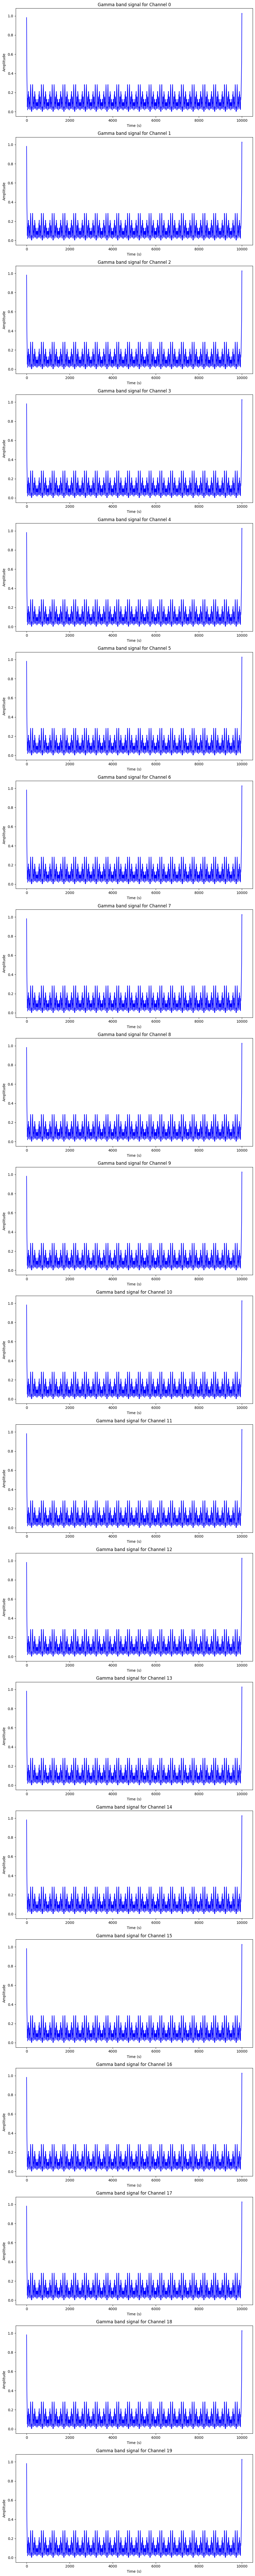

In [73]:
n_channels = 20
# n_channels = 1

fig, axs = plt.subplots(n_channels, 1, figsize=(10, 5*n_channels))

band = "Gamma"

for ch in range(n_channels):
    for i, stim in enumerate(y):
        if stim == 0:
            axs[ch].plot(np.abs(freq_band_eeg[i][band][ch]), color="blue")
        # else:
        #     axs[ch].plot(np.abs(freq_band_eeg[i][band][ch]), color="red")

    axs[ch].set_title(f"{band} band signal for Channel {ch}")
    axs[ch].set_xlabel("Time (s)")
    axs[ch].set_ylabel("Power")

plt.tight_layout()
plt.show()

# Motor Imagery Dataset

In [210]:
import warnings

from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

import moabb


moabb.set_log_level("info")
warnings.filterwarnings("ignore")

### Instantiate Dataset

In [211]:
from moabb.datasets import BNCI2014_001, BNCI2015_001

dataset = BNCI2015_001()
dataset.subject_list = [1, 2, 3]

### Access EEG Recordings

In [212]:
sessions = dataset.get_data(subjects=[1])

In [213]:
subject = 1
session_name = "0train"
run_name = "0"

sessions[subject]['0A']

{'0': <RawArray | 14 x 1099541 (2147.5 s), ~117.5 MB, data loaded>}

### Set Up Paradigm

In [214]:
dataset.paradigm

'imagery'

In [215]:
from moabb.paradigms import MotorImagery, LeftRightImagery 

paradigm = MotorImagery()

2024-08-01 15:05:18,226 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events


### Get data

In [216]:
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[1])
y = np.array([0 if label == "right_hand" else 1 for label in labels])

### Create Pipeline

In [219]:
X.shape

(400, 13, 2561)

In [220]:
from common_spatial_pattern import csp

n_components = 8

filters = csp(X[np.where(y==0)[0]], X[np.where(y==1)[0]])
filters = np.vstack([filters[:int(n_components/2)], filters[-int(n_components/2):]])

In [222]:
def extract_features(data, filters):
    filtered_data = np.dot(filters, data)

    return np.log(np.var(filtered_data, axis=2))

In [223]:
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [229]:
clf = LDA()

extracted_features_train = extract_features(X_train, filters).T
clf.fit(extracted_features_train, y_train)
# clf.score(extracted_features_train, y_train)

extracted_features_test = extract_features(X_test, filters).T
clf.score(extracted_features_test, y_test)

0.9

In [ ]:
pipeline = {}
pipeline["CSP+LDA"] = make_pipeline(CSP(n_components=8), LDA())

In [ ]:
pipeline["CSP+LDA"].fit(X_train, y_train)
pipeline["CSP+LDA"].score(X_test, y_test)

# scores = cross_val_score(pipeline["CSP+LDA"], X, y, cv=5)
# scores

1.0

### Create Frequency Bands

In [80]:
# BNCI2015_001 first 3 seconds are reference, sfreq is 512 Hz
X.shape

(400, 13, 2561)

In [ ]:
freq_band_eeg = []

for trial_data in X:
    coefficients, freqs = wavelet_transform(trial_data, 1024)

    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 70),
        'High Gamma': (70, 150)
    }
    
    band_signals = {}
    for band, (low_freq, high_freq) in bands.items():
        # Find the indices of frequencies within the band
        idx_band = np.logical_and(freqs >= low_freq, freqs <= high_freq)
        band_signals[band] = coefficients[idx_band, :, :].mean(axis=0)
    
    freq_band_eeg.append(band_signals)

### Compute Gamma Power

In [29]:
gamma_power = []

for trial in range(len(freq_band_eeg)):
    gamma_power.append(freq_band_eeg[trial]['High Gamma'])

gamma_power = np.array(gamma_power)

In [31]:
X.shape[2]

2561

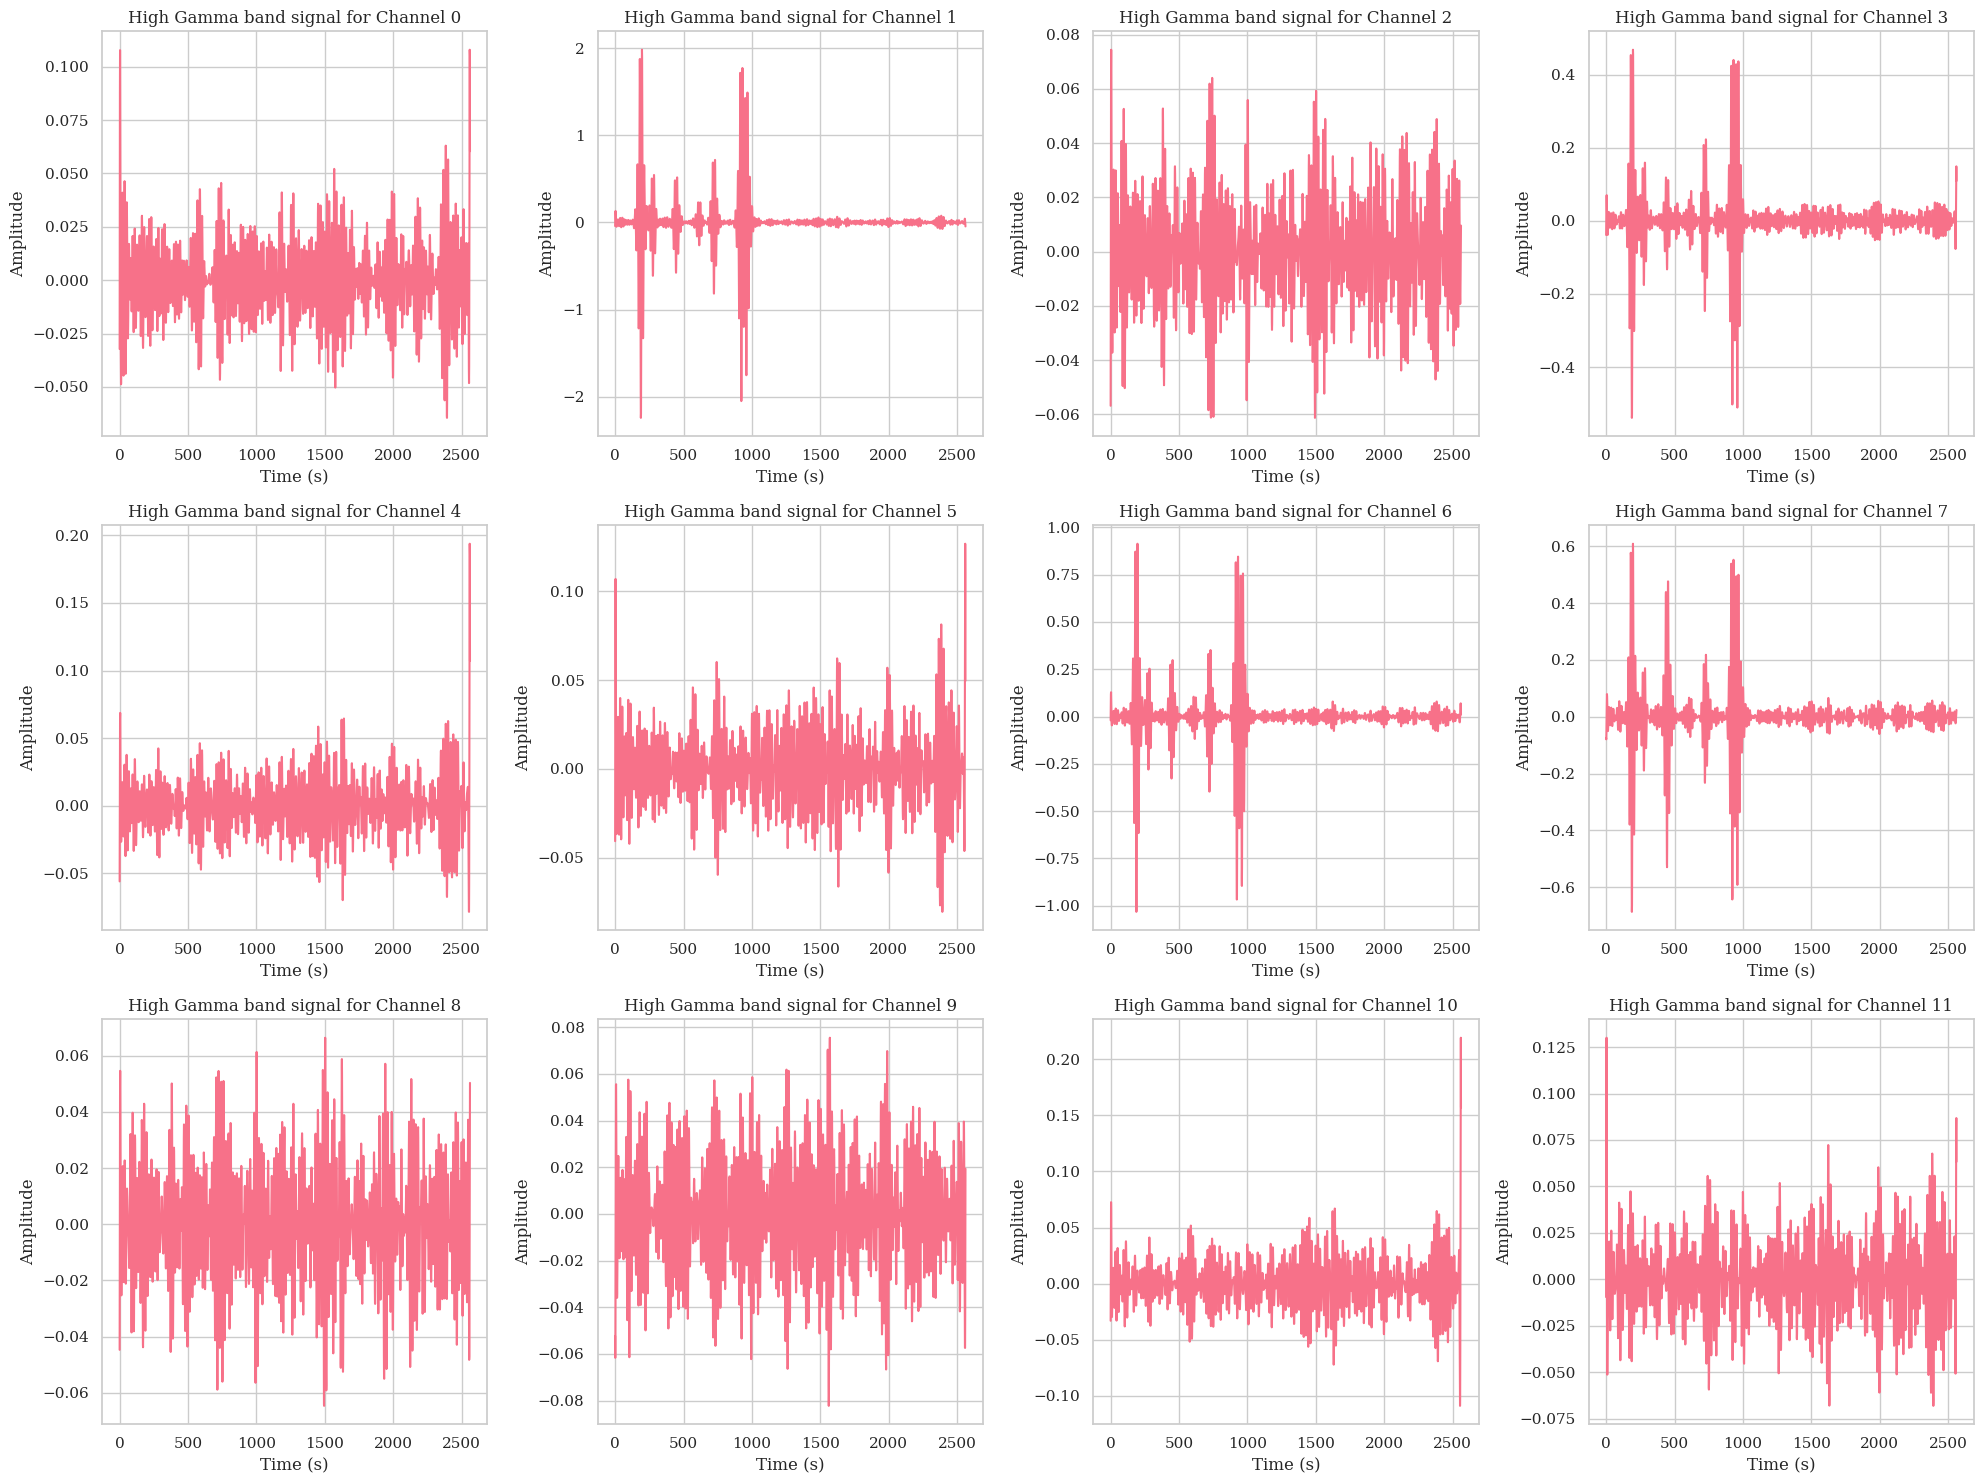

In [30]:
n_channels = X.shape[1]
mean_gamma_power = gamma_power[np.where(y==1)[0]].mean(axis=0)

n_cols = 4
n_rows = n_channels//n_cols


fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

for i in range(n_rows):
    for j in range(n_cols):
        ch = n_cols*i+j
        axs[i, j].plot(mean_gamma_power[ch])

        axs[i, j].set_title(f"High Gamma band signal for Channel {ch}")
        axs[i, j].set_xlabel("Time (s)")
        axs[i, j].set_ylabel("Amplitude")
    
        xtick_positions = np.linspace(0, 4, num=4)
        # xtick_labels = np.round(np.linspace(0, t_win[0], num=4), 2)
        axs[i, j].set_xticks(xtick_positions)
        # axs[i, j].set_xticklabels(xtick_labels)

plt.tight_layout()
plt.show()